<a href="https://colab.research.google.com/github/Yannngn/TAIL_Academico_07_2021/blob/main/Apresenta%C3%A7%C3%A3o_academico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 5.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
import statsmodels.api as sm

In [ ]:
sm.__version__

'0.12.2'

# 1. Introdução

## 1.1. Conceitos Básicos

### Séries Temporais:  
Conjunto de observações que seguem uma lógica temporal, geralmente sequêncialmente de forma contínua ou discreta, determinística ou não.

### Tendência
O comportamento de longa duração dos dados, em geral, se eles crescem, ou decrescem ou não variam, podemos observar a média de um intervalo de tempo fixo ao longo dos dados e observar seu comportamento

### Sazonalidade
O comportamento de curta duração dos dados, além do ruído, ou sujeira aleatória nos dados, há algum comportamento repetitivo nos dados? Se sim trata-se da sazonalidade.

### Estacionaridade
Pode ser fraca ou forte, em geral observamos a fraca, que contém média dos dados constante e variância destes também constante. Observe:

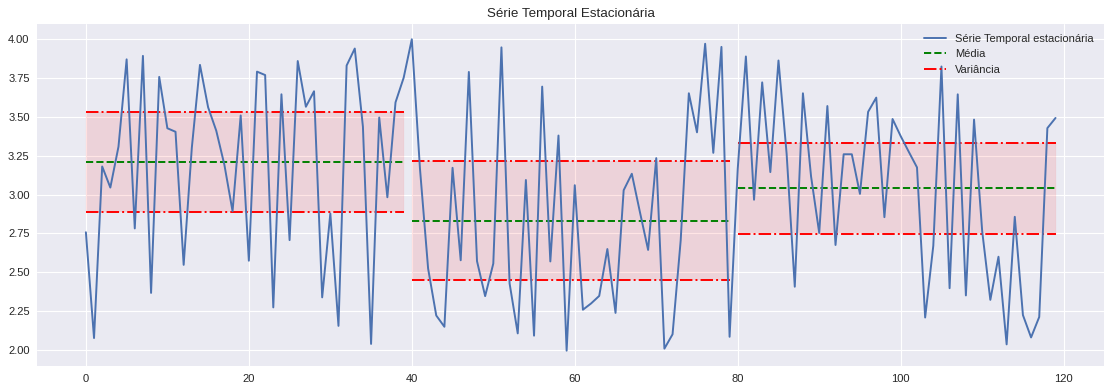

In [ ]:
n=120

x = np.arange(n)

y_ = np.random.uniform(-1, 1, [n])

mu = 3
sigma = 0.01
e = np.random.normal(mu, sigma, n)

y = y_ + e

plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.title('Série Temporal Estacionária')

m = 3
prev = 0
for i in range(1, m + 1) :

  a = int(i * n / m)
  b = int(n / m)

  mean = np.mean(y[a - b: a])
  var = np.var(y[a - b : a])

  plt.plot(x[a - b : a], [mean] * b, color='g', linestyle='--')
  plt.plot(x[a - b : a], [mean + var] * b, color='r', linestyle='-.')
  plt.plot(x[a - b : a], [mean - var] * b, color='r', linestyle='-.')

  plt.fill_between(x[a - b : a], [mean + var] * b, [mean - var] * b, color='r', alpha=0.1)

  prev = a

plt.plot(x, y, label='Série Temporal estacionária')
plt.plot(0, [mean], color='g', linestyle='--', label = 'Média')
plt.plot(0, [mean - var], color='r', linestyle='-.', label = "Variância")

plt.legend()
plt.tight_layout()
plt.show()

Num conjunto de dados estacionários, a média permanece constante (a medida que a quantidade de observações tende ao infinito), e a variância dos dados também permanece dessa forma. 

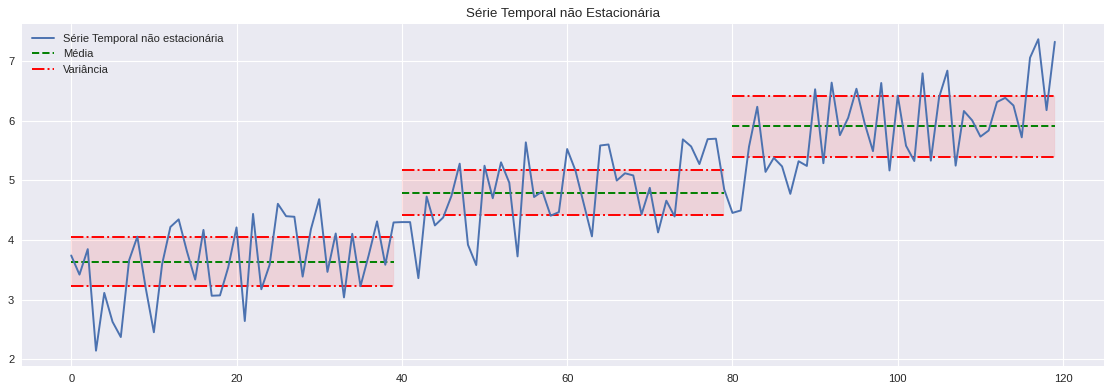

In [ ]:
n=120

x=np.arange(n)

y_=np.random.uniform(-1, 1, [n])

mu = 3
sigma = 0.01
e = np.random.normal(mu, sigma, n)

y = y_ + e + 0.03*x

plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.title('Série Temporal não Estacionária')

m = 3
prev = 0
for i in range(1, m + 1) :

  a = int(i * n / m)
  b = int(n / m)

  mean = np.mean(y[a - b: a])
  var = np.var(y[a - b : a])

  plt.plot(x[a - b : a], [mean] * b, color='g', linestyle='--')
  plt.plot(x[a - b : a], [mean + var] * b, color='r', linestyle='-.')
  plt.plot(x[a - b : a], [mean - var] * b, color='r', linestyle='-.')
  plt.fill_between(x[a - b : a], [mean + var] * b, [mean - var] * b, color='r', alpha=0.1)

  prev = a

plt.plot(x, y, label='Série Temporal não estacionária')
plt.plot(0, [mean], color='g', linestyle='--', label = 'Média')
plt.plot(0, [mean - var], color='r', linestyle='-.', label = "Variância")

plt.legend()
plt.tight_layout()
plt.show()

Já no caso do não estacionário, a média altera-se com o passar do tempo, assim como pode ocorrer com a variância

A maioria dos modelos necessita de um conjunto de dados estacionários, torná-los adequados é muito simples, é possível fazê-lo com o *Pandas* ou *NumPy* 

In [ ]:
def diferenca(dataset, interval=1):
  diff = list()
  
  for i in range(interval, len(dataset)) :
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  
  diff.insert(0, np.array(diff).mean())

  return diff

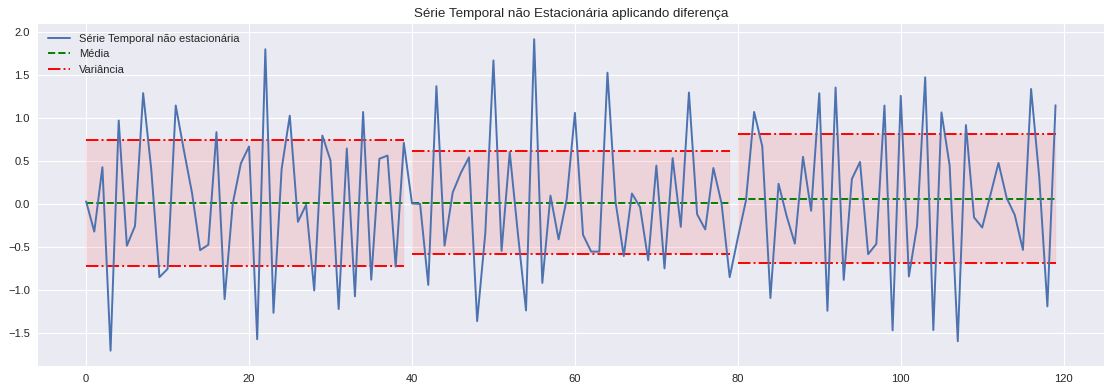

In [ ]:
y__ = diferenca(y)

plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.title('Série Temporal não Estacionária aplicando diferença')

m = 3
prev = 0
for i in range(1, m + 1) :

  a = int(i * n / m)
  b = int(n / m)

  mean = np.mean(y__[a - b: a])
  var = np.var(y__[a - b : a])

  plt.plot(x[a - b : a], [mean] * b, color='g', linestyle='--')
  plt.plot(x[a - b : a], [mean + var] * b, color='r', linestyle='-.')
  plt.plot(x[a - b : a], [mean - var] * b, color='r', linestyle='-.')
  plt.fill_between(x[a - b : a], [mean + var] * b, [mean - var] * b, color='r', alpha=0.1)

  prev = a

plt.plot(x, y__, label='Série Temporal não estacionária')
plt.plot(0, [mean], color='g', linestyle='--', label = 'Média')
plt.plot(0, [mean - var], color='r', linestyle='-.', label = "Variância")

plt.legend()
plt.tight_layout()
plt.show()

O *statsmodels* é a biblioteca *Python* com várias funções para trabalhar com Séries Temporais 

## 1.2. O Dataset

Os dados foram retirados do [Kagle](https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities?select=station_manaus.csv) e processados para conter uma única coluna com os dados mensais de Janeiro 1910 a Dezembro 2020

In [ ]:
df_1 = pd.read_csv('https://raw.githubusercontent.com/luiz826/csv_for_tail/main/manaus_mensal.csv')
df_2 = pd.read_csv('https://raw.githubusercontent.com/luiz826/csv_for_tail/main/manaus_anual.csv')

df_1['YEAR'] =  pd.to_datetime(df_1['YEAR'], format='%Y-%m-%d')
df_2['YEAR'] =  pd.to_datetime(df_2['YEAR'], format='%Y-%m-%d')

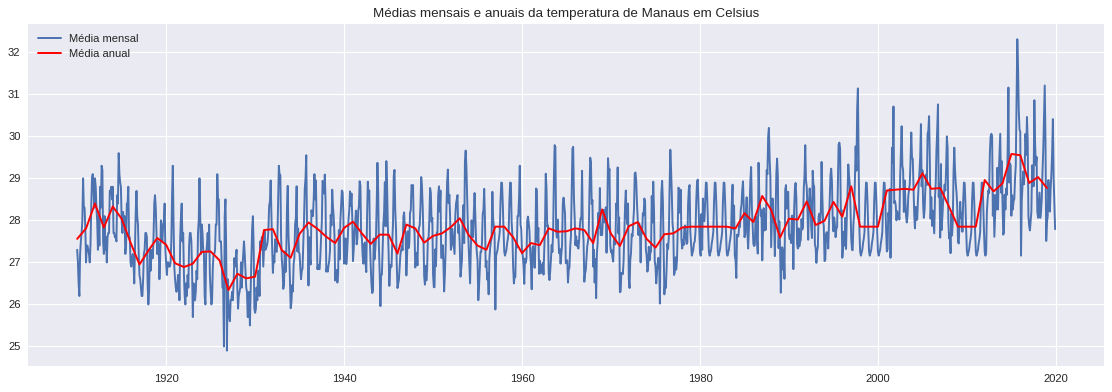

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize=[14,5], dpi=80)

plt.plot(df_1.YEAR, df_1.TEMPERATURE, label='Média mensal')
plt.plot(df_2.YEAR, df_2.metANN, color='r', label='Média anual')

plt.title("Médias mensais e anuais da temperatura de Manaus em Celsius")
plt.legend()
plt.tight_layout()
plt.show()

Os dados contém um leve tendência e uma sazonalidade anual não muito forte

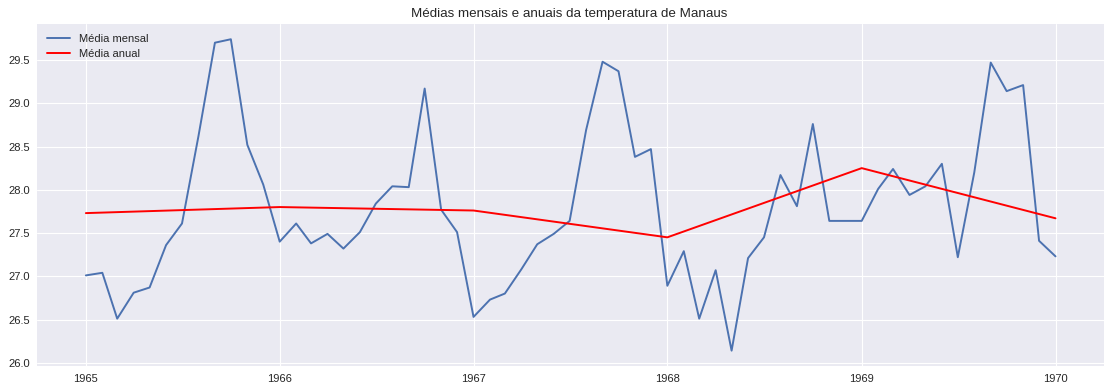

In [ ]:
n = 55

plt.style.use('seaborn')

plt.figure(figsize=[14,5], dpi=80)

plt.plot(df_1.YEAR[n * 12 : (n + 5) * 12 + 1], df_1.TEMPERATURE[n * 12 : (n + 5) * 12 + 1], label='Média mensal')
plt.plot(df_2.YEAR[n : n + 6], df_2.metANN[n : n + 6], color='r', label='Média anual')

plt.title("Médias mensais e anuais da temperatura de Manaus ")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Modelos 

## 2.1 Modelo Auto-regressivo

Modelos Autoregressivos tem como objetivo prever os proximos valores de uma série unicamente por seus valores passados. Funciona como uma regressão linear dos valores da própria série temporal. Eles servem apenas para séries estacionárias (pode ser as fracamente estacionárias).

Um modelo AR de ordem p, ou seja, AR(p), tem essa cara:

<center>

<h2> $y_{t} = φ_{0} + φ_{1}{.}y_{t−1} + φ_{2}{.}y_{t−2} + {. . .} + φ_{p}{.}y_{t−p} + µ_{t}$ </h2>

</center>

Onde $y_{t}$ é o valor que queremos prever, $y_{t-p}$ são os p valores anteriores a ele, $µ_{t}$ é um ruído branco e os $φ$ são os parametros da regressão.

Vamos focar no modelo mais simples, que é o AR (1):

<center>
<h2> $y_{t} = φ_0 + φ_1 {.} y_{t−1} + µ_{t}$</h2>
</center>

O modelo funciona recursivamente, por exemplo:
<center>    
<h2> $y_{t} = φ_0 + φ_1 {.} y_{t−1} + µ_{t}$</h2>

<h2> $y_{t-1} = φ_0 + φ_1 {.} y_{t−2}  + µ_{t-1}$</h2>
</center>

Mas $y_t$ depende de $y_{t-1}$, segundo o modelo, então:

<center> 
<h2>$y_t = φ_0 + φ_1 {.} (φ_0 + φ_1 {.} y_{t−2} + µ_{t-1})  + µ_t$ </h2>
</center>

E isso se repete até o início da série (o ultimo valor). Por esse motivo o modelo faz parte dos long memory models.

<center>
<img src="https://github.com/luiz826/csv_for_tail/blob/main/Screenshot%20from%202021-07-03%2017-23-26.png?raw=true" alt="AR(1) model" width=800 height=400>
</center>

<center> 
<img src="https://github.com/luiz826/csv_for_tail/blob/main/Screenshot%20from%202021-07-03%2017-23-42.png?raw=true" alt="AR(1) model" width=800 height=400>
</center> 



Mas é claro que a primeira observação não influencia tão fortemente na previsão. Por conta da estacionariedade, a dependencia de uma variável anterior vai declinando ao longo do tempo, por exemplo: $y_t$ depende mais de $y_{t-2}$ de que $y_{t-39}$, por conta da estacionariedade.

A atualização dos parametros φ pode ser feita de diversas formas como: Método dos Mínimos Quadrados, Algoritmo de Burg, Equações de Yuller-Walker e Estimativa de Máxima Verossimilhança.
Não focarei na explicação teorica deles.

A biblioteca que usaremos para implementar o modelo é a statsmodels, do python. A Classe implementada nesta biblioteca utiliza o método Estimativa de Máxima Verossimilhança para estimar os parâmetros.

Vamos usar o modelo AR para prever as temperaturas mensais de Manaus:

In [ ]:
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error 
import warnings
warnings.filterwarnings('ignore')

df_AM = df_1.copy()

In [ ]:
df_AM['YEAR'] =  pd.to_datetime(df_AM['YEAR'], format='%Y-%m-%d')
df_AM.set_index(df_AM['YEAR'], inplace=True)
df_AM.drop("YEAR", axis=1, inplace=True)

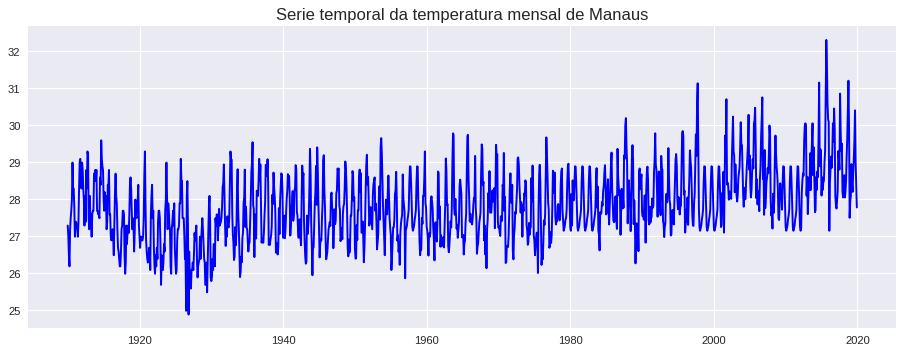

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=[14,5],  dpi=80)
plt.plot(df_AM, color="blue")
plt.title("Serie temporal da temperatura mensal de Manaus", fontsize=15)
plt.show()

Vamos definir o período de treino e de teste para o modelo:

In [ ]:
t_treino = df_AM.loc[:"2015-12-01"].index.values
t_teste = df_AM.loc["2016-01-01":].index.values
X_treino = df_AM.loc[:"2015-12-01"].values
X_teste = df_AM.loc["2016-01-01":].values

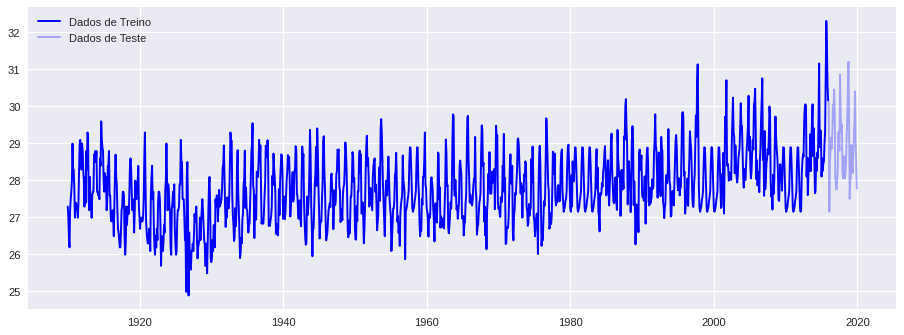

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.plot(t_treino,X_treino, color="blue", label="Dados de Treino")
plt.plot(t_teste,X_teste, color="blue", alpha=0.3, label="Dados de Teste")
plt.legend()
plt.show()

Até dez de 2010 para treino e o restante para testes.

Agora veremos os gráficos de Autocorrelação e Autocorrelação Parcial, para checar se os nossos dados são apropriados para um modelo AR e qual seria a sua ordem p.

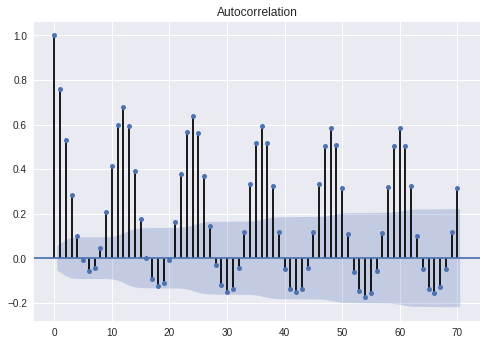

In [ ]:
plot_acf(X_treino, lags=70);

Percebe-se um "sobe e desce" na função acima, e isso indica que o modelo não se ajusta ao modelo AR, mas vamos seguir.

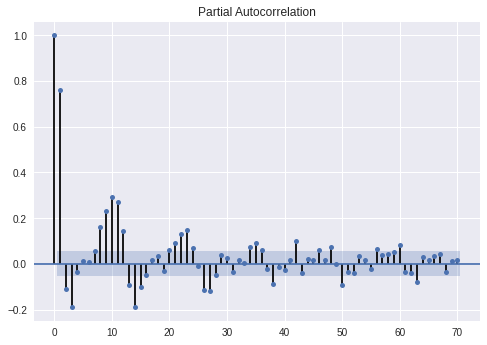

In [ ]:
plot_pacf(X_treino, lags=70);

Com este gráfico acima podemos enxergar possiveis pontos para p (a ordem do modelo). 

Os pontos mais favoráveis a serem o nosso p, são os que estão mais próximos do limite acima da área azul do gráfico. Com isso podemos testar alguns valores no modelo, como:

In [ ]:
l = []
possiveis_ordens = range(20,71)
for i in possiveis_ordens:
    modelo = AutoReg(X_treino, lags=i, trend="n")
    resultado = modelo.fit()
    X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)
    MSE = mean_squared_error(X_teste,X_pred)
    print(f"O erro quadrático de AR({i}) é {np.sqrt(MSE)}") 
    l.append(np.sqrt(MSE))

print(f"\n\t O menor erro quadrático foi do AR({np.argmin(l)+20})")

O erro quadrático de AR(20) é 1.2329314100550397
O erro quadrático de AR(21) é 1.173140955425559
O erro quadrático de AR(22) é 1.086544639983408
O erro quadrático de AR(23) é 0.991077878680711
O erro quadrático de AR(24) é 0.9647234882446054
O erro quadrático de AR(25) é 0.956060258612712
O erro quadrático de AR(26) é 0.9928988438810767
O erro quadrático de AR(27) é 1.0504436396684853
O erro quadrático de AR(28) é 1.0882088522812232
O erro quadrático de AR(29) é 1.0660669819271873
O erro quadrático de AR(30) é 1.0450327056619488
O erro quadrático de AR(31) é 1.0759438519033844
O erro quadrático de AR(32) é 1.0598893362490596
O erro quadrático de AR(33) é 1.0666302477945668
O erro quadrático de AR(34) é 1.0116145414127886
O erro quadrático de AR(35) é 0.9429524809031232
O erro quadrático de AR(36) é 0.9207610265864764
O erro quadrático de AR(37) é 0.9269439545493054
O erro quadrático de AR(38) é 0.9412137239130389
O erro quadrático de AR(39) é 0.9440960242613943
O erro quadrático de AR(

In [ ]:
p = 60

modelo = AutoReg(X_treino, lags=p, trend="n")

resultado = modelo.fit()

teste_pred = resultado.predict(start = len(X_treino), end = len(X_treino) + len(X_teste))
treino_pred = resultado.predict(end = len(X_treino) + len(X_teste))

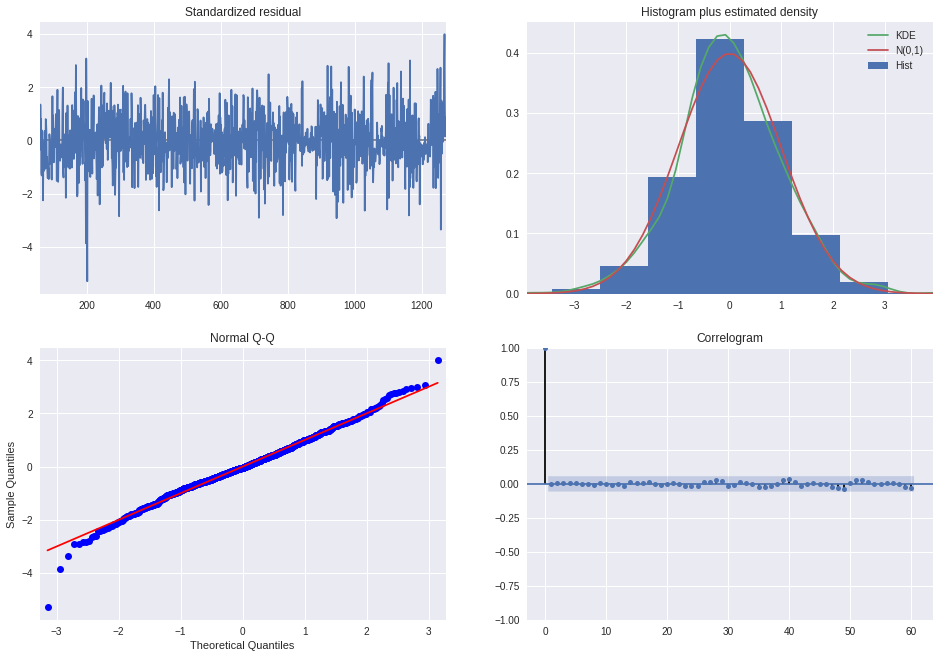

In [ ]:
resultado.plot_diagnostics(lags=p, figsize=[16,11]);

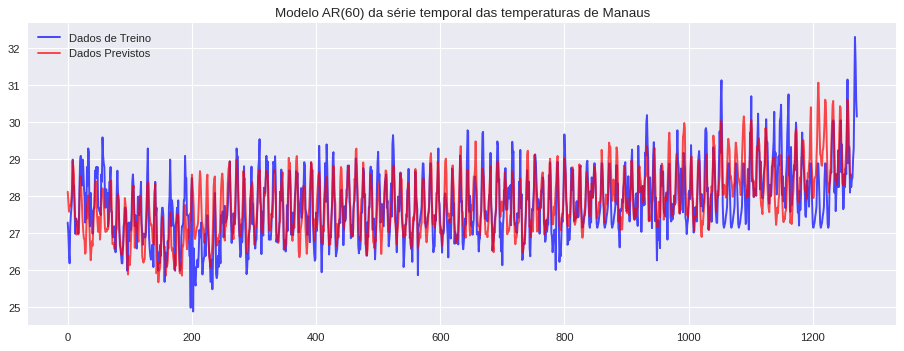

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.plot(X_treino, color="blue", alpha = 0.7, label="Dados de Treino")
plt.plot(treino_pred, color="red", alpha = 0.7, label="Dados Previstos")
plt.legend()
plt.title(f"Modelo AR({p}) da série temporal das temperaturas de Manaus")
plt.show()

Até que o modelo se ajustou bem aos dados de treino. Mas percebemos que os extremos não são alcançados pelo nosso modelo.


Agora vamos tentar predizer valores, com nossos dados de teste:

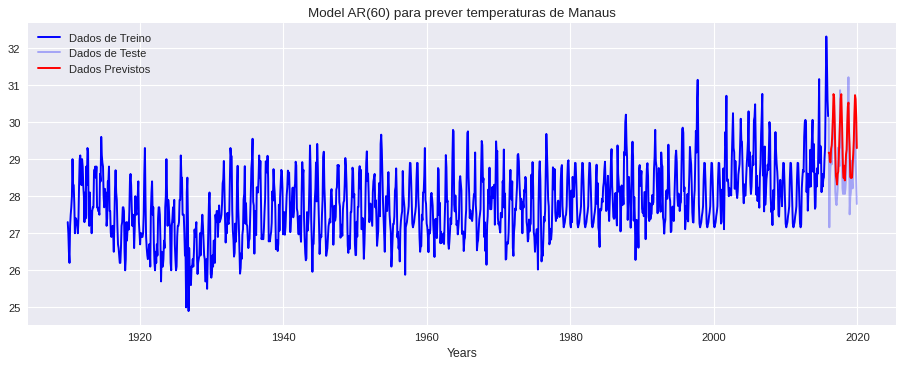

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.plot(t_treino,X_treino, color="blue", label="Dados de Treino")
plt.plot(t_teste,X_teste, color="blue", alpha=0.3, label="Dados de Teste")
plt.plot(t_teste,X_pred, color="red", label="Dados Previstos")
plt.legend()
plt.title(f"Model AR({p}) para prever temperaturas de Manaus")
plt.xlabel("Years")
plt.show()

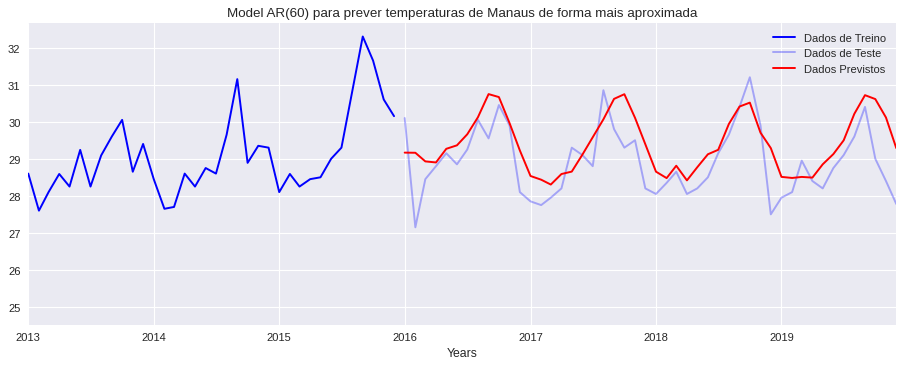

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.plot(t_treino,X_treino, color="blue", label="Dados de Treino")
plt.plot(t_teste,X_teste, color="blue", alpha=0.3, label="Dados de Teste")
plt.plot(t_teste,X_pred, color="red", label="Dados Previstos")
plt.legend()
plt.title(f"Model AR({p}) para prever temperaturas de Manaus de forma mais aproximada")
plt.xlabel("Years")
plt.xlim(t_treino[-36], t_teste[-1])
plt.show()

Analisando gráficamente, o nosso modelo AR(60) até que conseguiu se sair bem, dada a simplicidade do modelo. Porém ele peca muito quando se trata se atingir os estremos (máximos e mínimos) da nossa série.

## 2.2 Modelo de Médias Móveis

Na aplicação matemática de paradigmas computacionais, o Modelo de Médias Móveis representa um excelente meio de fazer estimativas (com reduzido, mas não nulo, risco de overfitting). Esse modelo possui uma variável de saída que depende de valores de uma entidade estocástica, sendo um tipo especial de Modelo Box-Jenkins.

Essa dependência atrelada à dinâmica estocástica indica que esse modelo se baseia em erros anteriores, os ciclos de iteração serão importantes na decisão da composição do modelo. O Modelo de Médias Móveis é sempre estacionário, porém nem sempre único.

Observação: Não confundir com a ferramenta estatística de Médias Móveis.

\

---

\

### Equação

Uma variável $y_t$ seguirá um Modelo de Médias Móveis de ordem $q$ se

<center>
<h2> $y_t = µ + u_t + θ_{1}{.}u_{t-1} + {. . .} + θ_q{.}u_{t-q}$ </h2>,
</center>

Sendo $u_t$ o ruído branco inerente ao modelo e $µ$ a média de $y_t$.

Essa equação pode ser reescrita como 

<center>
<h2> $y_t = µ + θ ( {\large B} ) {.} u_t$ </h2>,
</center>

Sendo $θ({\large B})$ o polinômio de médias móveis.

\

---

\

### Modelo de Médias Móveis na prática

Para entender de forma prática a aplicação do Modelo de Médias Móveis, vamos utilizar o Dataset de Séries Temporais de Temperatura na cidade de Manaus.




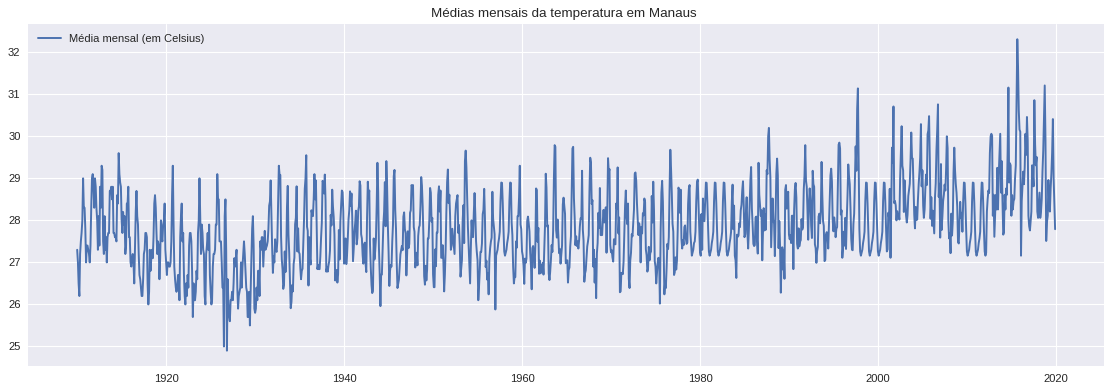

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize=[14,5], dpi=80)

data_form_month = df_1.copy()

data_form_month['YEAR'] =  pd.to_datetime(data_form_month['YEAR'], format='%Y-%m-%d')



plt.plot(data_form_month.YEAR, data_form_month.TEMPERATURE, label='Média mensal (em Celsius)')

plt.title("Médias mensais da temperatura em Manaus ")
plt.legend()
plt.tight_layout()
plt.show()

Definamos, a partir desse gráfico, onde será a região de treino e de teste.

In [ ]:
tempo_treino = data_form_month.loc[:'2015-12-01'].index.values
tempo_teste = data_form_month.loc['2016-12-01':].index.values
temperatura_treino = data_form_month.loc[:'2015-12-01'].values
temperatura_teste = data_form_month.loc['2016-01-01':].values

In [ ]:
len(tempo_treino),len(tempo_teste)

(202, 1118)

Agora podemos deduzir as regiões de treino e teste em gráfico.

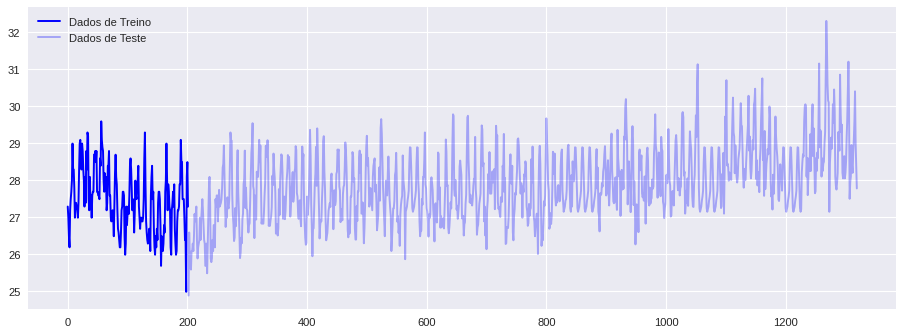

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=[14,5], dpi=80)
plt.plot(tempo_treino, temperatura_treino[:,1], color="blue", label="Dados de Treino")
plt.plot(tempo_teste, temperatura_teste[:,1], color="blue", alpha=0.3, label="Dados de Teste")
plt.legend()
plt.show()

Precisamos, primeiramente, analisar a autocorrelação do Dataset em questão.

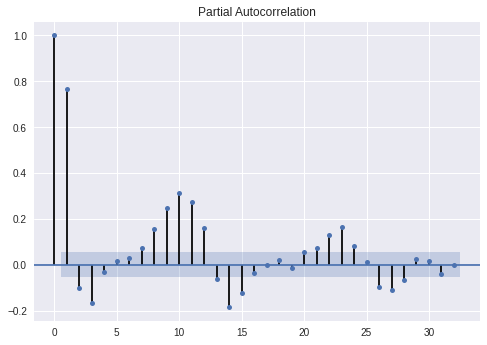

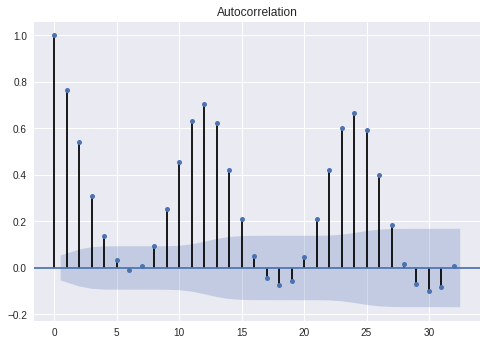

In [ ]:
plot_pacf(data_form_month['TEMPERATURE'])
plot_acf(data_form_month['TEMPERATURE']);

Encontremos, nesse paradigma, a ordem mais adequada pelo método de mínimos quadrados.

In [ ]:
menor_valor = 0
correct_index = 0
for i in range(0,40):
  model = AutoReg(tempo_treino, lags=i)
  result = model.fit()
  tempo_prev = result.predict(start=len(tempo_treino), end=len(tempo_treino)+len(tempo_teste)-1)
  MSE = mean_squared_error(tempo_teste.astype(float),tempo_prev)
  print(np.sqrt(MSE))
  if i==0 or np.sqrt(MSE)<menor_valor:
    menor_valor = np.sqrt(MSE)
    correct_index = i

print(f"{correct_index} é a ordem mais adequada") 


734.6837755116143
8.184518492081872e-11
2.847976864936753e-09
7.471040629480061e-10
2.1422652601338646e-09
1.1154800423684317e-08
8.047698773276359e-10
1.9966368299976975e-09
1.3455187902193833e-08
4.02273184995228e-09
2.6134969152322828e-09
4.307555784494047e-09
2.1427424731368786e-09
5.491199864077075e-09
3.307351342915892e-09
1.4961480923634302e-09
1.9290749724362544e-09
1.6982669202709905e-09
1.8926833149166836e-09
3.7418808142998926e-10
3.0775346552942307e-10
1.7663079629251723e-09
3.722630561315367e-09
9.908450794915616e-10
1.2687036641421292e-09
6.305020353547448e-10
2.602852175256192e-09
1.0206821086200966e-09
2.2142104627159216e-10
3.5854102257327133e-09
1.5372857742609256e-09
6.261644047086751e-10
1.2755468930125755e-10
8.385335848200793e-10
4.69197777076895e-10
3.45856496519276e-10
3.810623776500466e-10
3.1571341390613874e-10
7.234441204107697e-10
2.2766868729161257e-10
1 é a ordem mais adequada


Abaixo uma estimativa de MA(14), Modelo de Médias Móveis de Ordem 14.

In [ ]:
data_form_month

,YEAR,TEMPERATURE
0,1910-01-01,27.29
1,1910-02-01,26.99
2,1910-03-01,26.49
3,1910-04-01,26.19
4,1910-05-01,27.19
...,...,...
1315,2019-08-01,29.60
1316,2019-09-01,30.40
1317,2019-10-01,29.00
1318,2019-11-01,28.40


KeyError: ignored

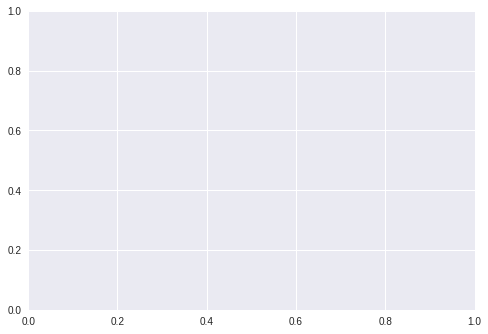

In [ ]:
from statsmodels.tsa.arima_model import ARMA

# plt.subplot(2, 1, 2)
# ar2 = np.array([1])
# ma2 = np.array([1, 0.9])
# MA_object2 = ArmaProcess(ar2, ma2)
# simulated_data_2 = MA_object2.generate_sample(nsample=1000)
# plt.plot(simulated_data_2);

mod = ARMA(data_form_month.TEMPERATURE,order=(0,14))
res = mod.fit()
res.plot_predict('2016','2020', dynamic=True, plot_insample=False)

plt.show()


Esse modelo é altamente optimizado comparado a um MA(1). A seguir:

KeyError: ignored

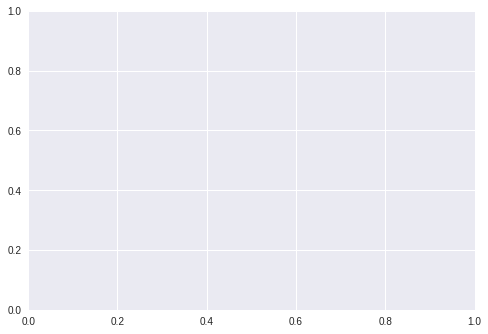

In [ ]:
mod = ARMA(data_form_month.TEMPERATURE,order=(0,1))
res = mod.fit()
res.plot_predict('2016','2020')

plt.show()

## 2.3 Modelo ARMA|ARIMA|SARIMA

O processo autorregressivo e de médias móveis (ARMA) consiste na “junção”
dos processos autorregressivo de ordem p, representado por AR(p), e médias móveis de ordem q, MA(q). A inclusão de termos autorregressivos e de médias móveis surge como uma alternativa para simplificar um modelo com grande número de parâmetros.

- Autoregressive moving-average (ARMA) model
    - ARMA = AR + MA
        - ARMA(1, 1) model:
$$ y_t = a_1 y_{t-1} + m_1 \epsilon_{t-1} + \epsilon_t $$
        - ARMA(p, q) model:
            - ordem p da AR
            - ordem q da MA

As condições de estacionariedade em relação ao processo AR e invertibilidade em relação ao MA permanecem.

Relembrando o comportamento dos dados ao longo do tempo:

In [ ]:
df_copy = df_1.copy()

In [ ]:
plt.figure(figsize=[30, 10])
plt.plot(df_copy["YEAR"], df_copy["TEMPERATURE"])

In [ ]:
df_copy['YEAR'] =  pd.to_datetime(df_copy['YEAR'], format='%Y-%m-%d')
df_copy.set_index(df_copy['YEAR'], inplace=True)
df_copy.drop("YEAR", axis=1, inplace=True)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(df_copy);
plot_acf(df_copy);

In [ ]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df_copy['TEMPERATURE'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

Aqui, o valor p é maior do que 0,05, o que significa que não podemos rejeitar a hipótese nula afirmando que a série temporal é não estacionária.

Portanto, devemos aplicar alguma transformação e alguma diferenciação para remover a tendência e remover a mudança na variância.
Tomaremos, portanto, a diferença logarítmica da série temporal. Isso é equivalente a pegar o logaritmo do EPS e, em seguida, aplicar a diferenciação uma vez. Observe que, como estamos diferenciando uma vez, nos livraremos do primeiro ponto de dados.

In [ ]:
df_copy['TEMPERATURE'] = np.log(df_copy['TEMPERATURE'])
df_copy['TEMPERATURE'] = df_copy['TEMPERATURE'].diff()
df_copy = df_copy.drop(df_copy.index[0])
df_copy.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df_copy['TEMPERATURE'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

Como vimos nas simulações para modelos ARMA mostradas anteriormente, as funções de autocorrelação e autocorrelação parcial não são informativas para definir a ordem dos modelos. Uma alternativa é fazer o uso de algum critério de informação. Neste caso, temos o Akaike’s Information Criterion (AIC) e o Bayesian Information Criterion (BIC) como opção.

O critério de informação é uma forma de encontrar o número ideal de parâmetros de um modelo. Para entendê-lo, tenha em mente que, a cada regressor adicional, a soma dos resíduos não vai aumentar; frequentemente, diminuirá. A redução se dá à custa de mais regressores. Para balancear a redução dos erros e o aumento do número de regressores, o critério de informação associa uma penalidade a esse aumento.

Tipicamente, para algum P e Q, computa-se o AIC ou BIC para diversos modelos ARMA(p,q), onde 0≤p≤P e 0≤q≤Q. Selecionamos o modelo que retorna o menor valor de AIC e/ou BIC. Esta abordagem requer estimação usando o princípio da máxima verossimilhança.



Akaike’s Information Criterion (AIC)

AIC = (−2/T) * ln(verossimilhança) + (2 * N / T)



In [ ]:
t_treino = df_copy.iloc[:int(.8*df_copy.shape[0])].index.values
t_teste = df_copy.iloc[int(.8*df_copy.shape[0]):].index.values
X_treino = df_copy.iloc[:int(.8*df_copy.shape[0])].values
X_teste = df_copy.iloc[int(.8*df_copy.shape[0]):].values

In [ ]:
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore')

def optimize_ARMA(order_list, values, dates):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = ARMA(values, dates=dates, order=order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
    print(results)
    result_df = pd.DataFrame(results)
    #result_df.columns = ['(p, q)', 'AIC']
    # #Sort in ascending order, lower AIC is better
    # result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
from tqdm import tqdm_notebook
from itertools import product

ps = range(0, 6)
qs = range(0, 6)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
    
result_df = optimize_ARMA(parameters_list, X_treino, t_treino)
result_df

In [ ]:
result_df

Opcional: Como otimizar o modelo escolhido

## 2.4 Outros

Opcional. Se quiserem falar do Prophet que é o modelo do facebook, ARIMAX, ou outras variações sintam-se livres

https://github.com/facebook/prophet